In [1]:
pip install split-folders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

# Path to the file in Google Drive
file_path = '/content/drive/My Drive/dataset_backup.zip'

# Destination path in /content/
destination_path = '/content/dataset_backup.zip'

# Copy the file
shutil.copy(file_path, destination_path)

'/content/dataset_backup.zip'

In [4]:
import zipfile

zip_path = 'dataset_backup.zip'  # Replace with the path to your zip file
extract_to = '/content/'  # Replace with the directory where you want to extract the contents

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted '{zip_path}' to '{extract_to}'")


Extracted 'dataset_backup.zip' to '/content/'


In [6]:
import numpy as np
import splitfolders
import tensorflow.keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import categorical_crossentropy
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

splitfolders.ratio('/content/dataset_backup/dataset',output='/content/datasplit', seed=1337, ratio=(0.7,0.2,0.1),group_prefix=None, move=False)

class_names=["2ASK","2FSK","4FSK","8FSK","BPSK","QAM16"]

#weights_path = 'E:/Drone_Signal_Classification/WITH_NOISE/Elsec_Dataset/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


datagen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow_from_directory(
    directory = "/content/datasplit/train",
    classes = class_names,
    target_size = (224,224),
    batch_size = 16,
    class_mode = "categorical",
    subset="training"
)


valid_generator = datagen.flow_from_directory(
    directory = "/content/datasplit/val",
    classes = class_names,
    target_size = (224,224),
    batch_size = 16,
    class_mode = "categorical",
)

test_generator = datagen.flow_from_directory(
    directory = "/content/datasplit/test",
    classes = class_names,
    target_size = (224,224),
    batch_size = 8,
    class_mode = "categorical",
    shuffle = False
)


model_vgg16 = VGG16(input_shape=(224,224,3),include_top = False,weights ="imagenet")

for layer in model_vgg16.layers:
  layer.trainable=False


model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(6,activation ="softmax"))

model.summary()

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])



Copying files: 30000 files [00:04, 7252.53 files/s]


Found 21000 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                              

In [7]:
history = model.fit(train_generator,validation_data = valid_generator,epochs = 30)

Epoch 1/30
1313/1313 [==============================] - 124s 89ms/step - loss: 0.5952 - accuracy: 0.7512 - val_loss: 0.3657 - val_accuracy: 0.8317
Epoch 2/30
1313/1313 [==============================] - 115s 88ms/step - loss: 0.4517 - accuracy: 0.7929 - val_loss: 0.3746 - val_accuracy: 0.8277
Epoch 3/30
1313/1313 [==============================] - 115s 88ms/step - loss: 0.4294 - accuracy: 0.8046 - val_loss: 0.3373 - val_accuracy: 0.8490
Epoch 4/30
1313/1313 [==============================] - 115s 88ms/step - loss: 0.4028 - accuracy: 0.8146 - val_loss: 0.3346 - val_accuracy: 0.8475
Epoch 5/30
1313/1313 [==============================] - 115s 88ms/step - loss: 0.4053 - accuracy: 0.8160 - val_loss: 0.3291 - val_accuracy: 0.8473
Epoch 6/30
1313/1313 [==============================] - 115s 88ms/step - loss: 0.3905 - accuracy: 0.8188 - val_loss: 0.3529 - val_accuracy: 0.8483
Epoch 7/30
1313/1313 [==============================] - 116s 88ms/step - loss: 0.3882 - accuracy: 0.8193 - val_loss: 0

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print("test loss: ", test_loss)
print("test accuracy: ", test_acc*100)

375/375 [==============================] - 19s 50ms/step - loss: 0.2959 - accuracy: 0.8653
test loss:  0.2958606481552124
test accuracy:  86.53333187103271


[0 0 0 ... 5 5 5]
375/375 [==============================] - 19s 51ms/step
[0 0 0 ... 5 5 5]


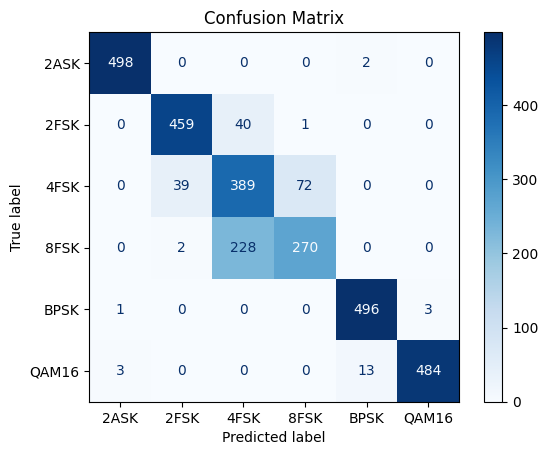

In [15]:
y_true =test_generator.classes
print(y_true)
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)
cm=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import precision_score,recall_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.8756
Recall: 0.8653


In [11]:
model.save('VGG16_Modulation_Multiclass_Classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import shutil

file_path = '/content/VGG16_Modulation_Multiclass_Classification.h5'

# Destination path within a folder in Google Drive
destination_path = '/content/drive/My Drive/VGG16_Modulation_Multiclass_Classification.h5'

# Copy the file
shutil.copy(file_path, destination_path)

'/content/drive/My Drive/VGG16_Modulation_Multiclass_Classification.h5'